# DFT Preprocessing

Here we convert our time series data to the frequency domain. 

From there, we can bin the data by frequency, which we can then use as attributes for our neural network.
The hoped-for advantage of this is that since FFT is fast enough to operate in real time, our final product may be able to support real-time HAR.

We can possibly later build on this by applying discrete wavelet transform (DWT) instead.

## Notes

(take a DSP class to learn more about this)

We know the sampling frequency is 20Hz, which gives us a Nyquist frequency of 10Hz, since this is the highest frequency signal that we can detect without aliasing. Therefore, if a higher frequency is present, it will be absorbed into the lower frequency range. There is nothing we can do about this, since the data is already collected, but it should be a safe assumption to make because most human activities should fall within the range of 0-10 Hz anyways (10Hz would be a period of 0.1 seconds and I don't think any of the activities involved in the study should have a movement component that exceeds this).

Since I've found the data is inconsistent with respect to its sampling frequency, I need to adjust. Only 2 samples have an average sampling frequency over 18Hz, so I will drop them and use 18 Hz as my minimum sampling frequency. Thus for consistency across samples, The highest frequency value will be 9, and there will be 15 cepstrum coefficients, dropping the first in favor of 


If we take the DFT of the entire sample, we'll find that the number of bins that we get is equal to the number of samples. This makes sense, but that's also a ton of bins, since each recording is 3 minutes long (~1200 frequency bins). We know that the size of each bin is $f_n = \frac{F_s}{N}$ so what we can do is reduce N by taking a windowed approach. Using a sliding window with a set size $N$, we'll compute the FFT in each window, shifting the window by $N$ each time (arbitrary), and at the end compute the average energy of each bin. 

We are borrowing several concepts from Speech Processing for this application, since speech processing also works with time series data, so most of processing techniques will be the same, except for the application of filter banks in the mel scale. The triangle filters will be evenly spaced and applied uniformly to generate the final frequency bins. This [website](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html) is excellent for understanding what i'm talking about. 

Here, we compute the FFT, then the power spectrum from that, and then apply triangle filters to get the relevent frequency bands. Unfortunately, the triangle filters introduce high correlation (since the filters overlap), so instead of using the filtered power spectrum as features, we will use cepstral coefficients produced via discrete cosine transform on the resulting filtered power spectrum. Intuitively, we can think of the cepstral coefficients as denoting how frequencies are changing over time. 



might not like using the latter part and come back to try using perfect square filters. this would have the benefit of introducing no overlap, and should intuitively give us less correlation. Mathematically, there is the danger of losing information at the filter boundaries, but since we're dealing with discrete data, we can avoid this. (i think?)

In [1]:
import pandas as pd
import numpy as np
import json
from scipy.fft import rfft, rfftfreq, dct
from glob import glob
import os
import sys
from time import time
import multiprocessing as mp
from multiprocessing import Manager, Pool, Lock
from math import sqrt
from pprint import pprint
from bins import Bins
import matplotlib.pyplot as plt
%matplotlib inline

# set multiprocessing to use 'fork' instead of 'spawn'
# issue details here: https://github.com/ipython/ipython/issues/12396
# note, map_async will still hang
mp.set_start_method('fork')

# relative path to the raw folder of the wisdm dataset
RAW_DIR_PATH = "../wisdm-dataset/raw/"


# some global information
col_names = ['id', 'label', 'timestamp', 'x', 'y', 'z']
dtypes = ['int64', 'object', 'int64', 'float64', 'float64', 'float64']

In [2]:
from numbers import Real

# generator for calculating the average iteratively
def _avg():
    avg, val, n = 0, 0, 1
    while True:
        val = (yield avg)
        if not isinstance(val, Real):
            avg = 0
            val = 0
            n = 1
            continue
        # recurrence relation
        avg = (avg * (n - 1) / n) + val / n
        n += 1

# generator for calculating the variance iteratively
def _var():
    avg, var, va, n = 0, 0, 0, 1
    gen_avg = _avg()
    next(gen_avg)
    while True:
        val = (yield var)
        if not isinstance(val, Real):
            avg = 0
            var = 0
            n = 1
            gen_avg.send('reset')
            continue
        new_avg = gen_avg.send(val)
        # recurrence relation
        var = var + avg**2 - new_avg**2 + (val**2 - var - avg**2) / n + 1
        avg = new_avg
        n += 1

In [3]:
# function that reads and processes a file and adds it to
#   the results dictionary with the subject id as key
def process_file(filepath):
    # user feedback
    filename = os.path.split(filepath)[1]
    # print(f"processing file: {filename}", flush=True)
    tf = time()

    # get the subject id from the filename
    sid = filename.split('_')[1]
    
    with open(filepath, 'r') as file:

        # process raw text files into a json-readable dictionary format
        raw = []
        for line in file.readlines():
            # clean the line and convert to a list
            data = line.rstrip(';\n').split(',')

            # turn the list into a dictionary and append it to raw list
            # raw.append(dict(zip(col_names, data)))
            
            raw.append(data)

    # convert raw to a json string and write it to a dataframe
    # raw_df = pd.read_json(json.dumps(raw),
    #                       orient='records',
    #                       dtype=dict(zip(col_names, dtypes)),
    #                       convert_dates=False
    #                      )

    raw_df = pd.DataFrame(raw, columns=col_names).astype(dict(zip(col_names, dtypes)))

    # generate groupby object by the label
    grouped_df = raw_df.groupby(raw_df.label)

    # construct dictionary of each group with unique label
    raw_dict = {}
    for l in grouped_df.groups:

        # get the dataframe for the label
        df = grouped_df.get_group(l).copy(deep=True)

        # reset the index and drop the 'index' label
        df = df.reset_index().drop(labels=['index'], axis=1)

        # initialize generators
        avg_gen = _avg()
        var_gen = _var()
        
        # compute average and standard deviation of sample spacing
        average = next(avg_gen)
        variance = next(var_gen)
        for i in range(1, len(df['timestamp'])):
            diff = int(df['timestamp'][i] - df['timestamp'][i-1])
            average = avg_gen.send(diff)
            variance = var_gen.send(diff)
        
        # add to dictionary
        raw_dict[l] = {
            'df': df,
            'avg ts': average,
            'stdv ts': sqrt(variance)
        }
    
    print(f"{filename.split('_')[1]} processed in {time()-tf}\n", flush=True, end='')
    
    return (sid, raw_dict)
#     # write the final dictionary to the results dictionary
#     results[sid] = raw_dict

In [4]:
# loop through each subdirectory
subdirs = ["phone/accel/", "phone/gyro/", "watch/accel/", "watch/gyro/"]
all_results = {}
for subdir in subdirs:
    
    # graph a list of all files in the subdirectory
    filenames = glob(f"{RAW_DIR_PATH}{subdir}/*")
    
    # remove any empty strings
    filenames = [name for name in filenames if name]
    
    # sort the list
    filenames.sort()
    
    # process data with multiprocessing
    
    # was going to use a manager, but a pool might be faster anyways
    
    # timing information
    print(f"\nHandling Subdirectory: {subdir}\n")
    t = time()
    
    with Pool(processes=2) as pool:
        
        # map processing function and store results in list
        results = pool.map(process_file, filenames)
    
    # data = []
    # for filepath in filenames:
    #     print(f"Processing File: {os.path.split(filepath)[1]}", flush=True)
    #     tf = time()
    #     data.append(process_file(filepath))
    #     print(f"Done! Elapsed Time: {time()-t}")
    
    all_results[subdir] = dict(results)
    
    # timing
    elapsed = time() - t
    print(f"\nDone! Elapsed Time: {elapsed}")


Handling Subdirectory: phone/accel/

1600 processed in 1.3327739238739014
1607 processed in 1.5687851905822754
1601 processed in 1.4601879119873047
1608 processed in 1.7377450466156006
1602 processed in 1.4814319610595703
1609 processed in 1.11415696144104
1603 processed in 1.4580390453338623
1610 processed in 1.4916720390319824
1604 processed in 1.4346797466278076
1611 processed in 1.441910982131958
1612 processed in 1.1161391735076904
1605 processed in 1.4238190650939941
1606 processed in 1.1457488536834717
1613 processed in 1.5470218658447266
1621 processed in 1.5271539688110352
1622 processed in 1.1293740272521973
1614 processed in 2.9617931842803955
1615 processed in 1.1570281982421875
1623 processed in 1.789139986038208
1624 processed in 1.1258270740509033
1616 processed in 1.7883038520812988
1617 processed in 2.360929012298584
1625 processed in 3.4904401302337646
1618 processed in 1.4867908954620361
1626 processed in 2.3526110649108887
1619 processed in 2.226925849914551
1620 p

In [127]:
def process_freq(df, ts, label):
    tp = time()
    # this function assumes that the data is mostly evenly spaced. since in reality the
    # data we are working with is not, there will probably be some error in the final results
    # how badly this propagates is yet to be seen
    
    # average sampling rate
    fs = 1/ts 
    
    # code is largely taken from this excellent blog post:
    # https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
    
    x = df['x'].to_numpy()
    y = df['y'].to_numpy()
    z = df['z'].to_numpy()
    
    # pre-emphasis (may be excluded later)
    alpha = 0.97
    x_emph = np.append(x[0], x[1:] - alpha * x[:-1])
    y_emph = np.append(y[0], y[1:] - alpha * y[:-1])
    z_emph = np.append(z[0], z[1:] - alpha * z[:-1])
    
    # framing
    # the principle is the same, but since human motion is much lower frequency than 
    # speech, we will pick much larger frame size and stride than the article. 
    # our whole data is 3 min, so to save on computation time, and since we will be 
    # averaging the frames together at the end for simplicity, we'll choose (in seconds)
    fsize = 60
    fstride = 30
    
    flen = int(round(fsize * fs))
    fstep = int(round(fstride * fs))
    
    siglen = len(x_emph)  # they should all be the same
    fnum = int(np.ceil(float(np.abs(siglen - flen)) / fstep))
    
    # zero pad the end of the signal so we don't have indexing error
    # and so we don't have to truncate
    paddedlen = fnum * fstep + flen
    pad = np.zeros((paddedlen - siglen))
    x_pad = np.append(x_emph, pad)
    y_pad = np.append(y_emph, pad)
    z_pad = np.append(z_emph, pad)
    
    idxs = np.tile(np.arange(0, flen), (fnum, 1)) + np.tile(np.arange(0, fnum * fstep, fstep), (flen, 1)).T
    idxs = idxs.astype(np.int32, copy=False)
    x_frames = x_pad[idxs]
    y_frames = y_pad[idxs]
    z_frames = z_pad[idxs]
    
    # apply window function (hamming window)
    # reasons are as stated in the blog post
    x_frames *= np.hamming(flen)
    y_frames *= np.hamming(flen)
    z_frames *= np.hamming(flen)
    
    # compute N-point FFT and compute power spectrum
    # thing says use 256 or 512, but i'm going to use the full frame length
    NFFT = flen
    x_mag = np.absolute(rfft(x_frames, n=NFFT))    # magnitude of fft
    y_mag = np.absolute(rfft(y_frames, n=NFFT))
    z_mag = np.absolute(rfft(z_frames, n=NFFT))
    
    x_pow = (((x_mag) ** 2) / NFFT)
    y_pow = (((y_mag) ** 2) / NFFT)
    z_pow = (((z_mag) ** 2) / NFFT)
    
    # apply filter banks to get the bands of the power spectrum
    # unlike the blog, we are not converting to the mel spectrum
    # so although this process is very similar to MFCC, it isn't the same.
    nfilt = 16    # interested in 0 to 10 Hz
    # note we go to 11 Hz because the last triangle corresponding to 10 ends on it.
    bins = np.floor((NFFT + 1) * np.linspace(0, 9, nfilt+2) / fs)
    
    # note that the filter bank ignores 0 frequency since it is just DC term
    # the original post uses overlapping triangle filters, but these introduce 
    # significant correlation. to decorrelate, he uses an additional DCT, though
    # this again introduces more computation time. (hopefully not too much...)
    
    # constructing the filter
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for i in range(1, nfilt + 1):
        f_left = int(bins[i - 1])
        f = int(bins[i])
        f_right = int(bins[i+1])
        
        for k in range(f_left, f):
            fbank[i - 1, k] = (k - bins[i-1]) / (bins[i] - bins[i-1])
        for k in range(f, f_right):
            fbank[i - 1, k] = (bins[i+1] - k) / (bins[i + 1] - bins[i])
    
    # applying the filter
    x_pow_fil = np.dot(x_pow, fbank.T)
    y_pow_fil = np.dot(y_pow, fbank.T)
    z_pow_fil = np.dot(z_pow, fbank.T)
    
    x_mag_fil = np.dot(x_mag, fbank.T)
    y_mag_fil = np.dot(y_mag, fbank.T)
    z_mag_fil = np.dot(z_mag, fbank.T)
    
    # get rid of zeros for numerical stability
    x_pow_fil = np.where(x_pow_fil == 0, np.finfo(float).eps, x_pow_fil)
    y_pow_fil = np.where(y_pow_fil == 0, np.finfo(float).eps, y_pow_fil)
    z_pow_fil = np.where(z_pow_fil == 0, np.finfo(float).eps, z_pow_fil)
    
    # conversion to decibels
    x_db = 20 * np.log10(x_pow_fil)
    y_db = 20 * np.log10(y_pow_fil)
    z_db = 20 * np.log10(z_pow_fil)
    
    # compute cepstral coefficients (keep 12 as in speech recognition, since 
    # the first coefficient represents the DC bias of the frequencies, and 
    # there shouldn't be too much variation in frequencies, but this might not be the case)
    x_cc = dct(x_db, axis=1, norm='ortho')[:, 1:16]
    y_cc = dct(y_db, axis=1, norm='ortho')[:, 1:16]
    z_cc = dct(z_db, axis=1, norm='ortho')[:, 1:16]
    
    # compute the averages of returned entities
    x_mag_avg = np.mean(x_mag_fil, axis=0)
    y_mag_avg = np.mean(y_mag_fil, axis=0)
    z_mag_avg = np.mean(z_mag_fil, axis=0)
    x_pow_avg = np.mean(x_pow_fil, axis=0)
    y_pow_avg = np.mean(y_pow_fil, axis=0)
    z_pow_avg = np.mean(z_pow_fil, axis=0)
    x_cc_avg = np.mean(x_cc, axis=0)
    y_cc_avg = np.mean(y_cc, axis=0)
    z_cc_avg = np.mean(z_cc, axis=0)
    
    # will not apply liftering because we might not need it.
    # return the averaged results (hopefully they look good)
    results = {
        'xmag': x_mag_avg,
        'ymag': y_mag_avg,
        'zmag': z_mag_avg,
        'xpow': x_pow_avg,
        'ypow': y_pow_avg,
        'zpow': z_pow_avg,
        'xcc': x_cc_avg,
        'ycc': y_cc_avg,
        'zcc': z_cc_avg
    }
    
#     print(f"Elapsed Time: {time() - tp}")
    return (label, results)

In [130]:
# now loop through and do frequency analysis for every file, 
# dropping bad data
# define bad data as:
#   std dev sampling period > 0.5% average sampling period
#   average sampling period >= 55 ms

feat_order = ['xmag', 'ymag', 'zmag', 'xpow', 'ypow', 'zpow', 'xcc', 'ycc', 'zcc']

def write_processed(args):
    (data, filename) = args
    t = time()
    # generate argument list
    args = [(data[l]['df'], data[l]['avg ts'] * (10**-9), l) for l in data.keys() \
            if 'avg ts' in data[l] \
            and data[l]['avg ts'] < 55000000 \
            and data[l]['stdv ts'] <= data[l]['avg ts'] * 0.05]

    # this is a pretty fast process, so we can just run it for all of them in a file
    results = [process_freq(*arg) for arg in args]

    results = dict(results)
    
    with open(filename, 'w') as file:
        s = ','.join([
            ','.join([f'xmag{round(i/2, 1)}' for i in range(1,17)]),
            ','.join([f'ymag{round(i/2, 1)}' for i in range(1,17)]),
            ','.join([f'zmag{round(i/2, 1)}' for i in range(1,17)]),
            ','.join([f'xpow{round(i/2, 1)}' for i in range(1,17)]),
            ','.join([f'ypow{round(i/2, 1)}' for i in range(1,17)]),
            ','.join([f'zpow{round(i/2, 1)}' for i in range(1,17)]),
            ','.join([f'xcc{i}' for i in range(1,16)]),
            ','.join([f'ycc{i}' for i in range(1,16)]),
            ','.join([f'zcc{i}' for i in range(1,16)])
        ]) + ',label\n'
        file.write(s)
        for label, rdict in results.items():
            s = ""
            for feat in feat_order:
                s += ",".join([f"{val}" for val in rdict[feat]])
                s += ','
            s += label + '\n'
            file.write(s)
    
    print(f"{os.path.split(filename)[1]} written to file in {time()-t} seconds!", flush=True)

for subdir in subdirs:
    
    context = subdir.strip('/').split('/')
    base = "_".join(context) + ".txt"
    
    args = [(data, "../data/" + str(sid) + '_' + base) for sid, data in all_results[subdir].items()]
    
    t = time()
    
    print("Starting Processes...", flush=True)
    
    # again apply multiprocessing to handle a lot of data
    with Pool(processes=2) as pool:
        
        # use starmap for multiple arguments
        pool.map(write_processed, args)
        
    print(f"\nDone! Finished in {time()-t} seconds")

Starting Processes...
1600_phone_accel.txt written to file in 0.07686805725097656 seconds!
1601_phone_accel.txt written to file in 0.07239603996276855 seconds!
1607_phone_accel.txt written to file in 0.27713894844055176 seconds!
1602_phone_accel.txt written to file in 0.282670259475708 seconds!
1608_phone_accel.txt written to file in 0.4434080123901367 seconds!1603_phone_accel.txt written to file in 0.4459991455078125 seconds!

1609_phone_accel.txt written to file in 0.1822519302368164 seconds!
1604_phone_accel.txt written to file in 0.23986005783081055 seconds!
1610_phone_accel.txt written to file in 0.2133650779724121 seconds!
1605_phone_accel.txt written to file in 0.1789700984954834 seconds!
1611_phone_accel.txt written to file in 0.10435104370117188 seconds!
1606_phone_accel.txt written to file in 0.10940885543823242 seconds!
1612_phone_accel.txt written to file in 0.1736619472503662 seconds!
1613_phone_accel.txt written to file in 0.11418890953063965 seconds!
1614_phone_accel.txt

1615_watch_accel.txt written to file in 0.1277449131011963 seconds!
1621_watch_accel.txt written to file in 0.16549301147460938 seconds!
1616_watch_accel.txt written to file in 0.18879222869873047 seconds!
1617_watch_accel.txt written to file in 0.0797879695892334 seconds!1622_watch_accel.txt written to file in 0.14406108856201172 seconds!

1618_watch_accel.txt written to file in 0.0958700180053711 seconds!
1623_watch_accel.txt written to file in 0.09830093383789062 seconds!
1624_watch_accel.txt written to file in 0.08456206321716309 seconds!
1619_watch_accel.txt written to file in 0.09434080123901367 seconds!
1625_watch_accel.txt written to file in 0.09163904190063477 seconds!
1620_watch_accel.txt written to file in 0.11117267608642578 seconds!
1626_watch_accel.txt written to file in 0.23078107833862305 seconds!
1627_watch_accel.txt written to file in 0.17698907852172852 seconds!
1628_watch_accel.txt written to file in 0.08343863487243652 seconds!
1629_watch_accel.txt written to file 

## Resources and Helpful Links



### Links

- [Tutorial: Fourier Transforms](https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html)
- [fft vs rfft](https://stackoverflow.com/questions/52387673/what-is-the-difference-between-numpy-fft-fft-and-numpy-fft-rfft)
- [fft vs fftfreq](https://stackoverflow.com/questions/59979354/what-is-the-difference-between-numpy-fft-fft-and-numpy-fft-fftfreq)
- [scipy fft vs numpy fft](https://stackoverflow.com/questions/47307862/why-do-scipy-and-numpy-fft-plots-look-different)
- [fft frequency ranges](https://stackoverflow.com/questions/30067812/reducing-a-fft-spectrum-range)
- [fft frequency bins](https://dsp.stackexchange.com/questions/40766/calculating-values-of-frequency-bins-in-python)

#### Function Documentation


- [scipy.fft](https://docs.scipy.org/doc/scipy/reference/fft.html)
- [scipy.fft.rfft](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.rfft.html#scipy.fft.rfft)
- [scipy.fft.rfftfreq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.rfftfreq.html#scipy.fft.rfftfreq)
- [scipy.fft.dct](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dct.html#scipy.fft.dct)

#### Misc

- [multiprocessing pool tutorial (doc)](https://docs.python.org/3/library/multiprocessing.html#sharing-state-between-processes)
- [multiprocessing pool (doc)](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool)
- [multiprocessing manager (doc)](https://docs.python.org/3/library/multiprocessing.html#managers)
- [multiprocessing manager dictionary (so)](https://stackoverflow.com/questions/6832554/)
- [multiprocessing child errors (so)](https://stackoverflow.com/questions/19924104/)
- [multiprocessing reading data in parallel (blog)](https://reijz.github.io/blog/python-read-data-parallel/)
- [multiprocessing parallel log files (blog)](https://willcecil.co.uk/multiprocessing-in-python-to-speed-up-log-file-processing/)
- [multiprocessing multiple files (so)](https://stackoverflow.com/questions/23794207/multiprocess-multiple-files-in-a-list)


## Scratch Work

In [112]:
from numbers import Real
t = time()
tf = time()
periods = []
bad_data = []
sample_periods = Bins([float('-inf'), 45*(10**6), 55*(10**6), float('inf')])
avg_periods = Bins([float('-inf'), 45*(10**6), 55*(10**6), float('inf')])

def _avg():
    avg, val, n = 0, 0, 1
    while True:
        val = (yield avg)
        if not isinstance(val, Real):
            avg = 0
            val = 0
            n = 1
            continue
        avg = (avg * (n - 1) / n) + val / n
        n += 1

def _var():
    avg, var, va, n = 0, 0, 0, 1
    gen_avg = _avg()
    next(gen_avg)
    while True:
        val = (yield var)
        if not isinstance(val, Real):
            avg = 0
            var = 0
            n = 1
            gen_avg.send('reset')
            continue
        new_avg = gen_avg.send(val)
        var = var + avg**2 - new_avg**2 + (val**2 - var - avg**2) / n + 1
        avg = new_avg
        n += 1
        
# loop through each subdirectory
subdirs = ["phone/accel/", "phone/gyro/", "watch/accel/", "watch/gyro/"]
for subdir in subdirs:
    
    # graph a list of all files in the subdirectory
    filenames = glob(f"{RAW_DIR_PATH}{subdir}/*")
    
    # remove any empty strings
    filenames = [name for name in filenames if name]
    
    # sort the list
    filenames.sort()
    
    
    # loop through each file
    for filename in filenames:
        
        # user feedback
        print(f"processing file: {os.path.split(filename)[1]}", flush=True)
        tf = time()
        avg_gen = _avg()
        var_gen = _var()
        average = next(avg_gen)
        variance = next(var_gen)
        
        with open(filename, 'r') as file:
            
            # process raw text files into a json-readable dictionary format
            raw = []
            cnt = 0
            label = 'A'
            for line in file.readlines():
                # clean the line and convert to a list
                data = line.rstrip(';\n').split(',')
                
                # turn the list into a dictionary and append it to raw list
                raw.append(dict(zip(col_names, data)))
                
                if cnt and raw[-1]['label'] == label:
                    diff = int(raw[-1]['timestamp']) - int(raw[-2]['timestamp'])
                    average = avg_gen.send(diff)
                    variance = var_gen.send(diff)
                    sample_periods.add(diff)
                elif cnt:
                    print("{} Average Sample Period: {:<20} Std Dev: {:>18}".format(label, average, "%0.6f"%(sqrt(variance))))
                    avg_periods.add(average)
                    average = avg_gen.send('reset')
                    variance = var_gen.send('reset')
                    
                cnt += 1
                label = raw[-1]['label']
                
                
#         # convert raw to a json string and write it to a dataframe
#         raw_df = pd.read_json(json.dumps(raw),
#                               orient='records',
#                               dtype=dict(zip(col_names, dtypes)),
#                               convert_dates=False
#                              )

#         # generate groupby object by the label
#         grouped_df = raw_df.groupby(raw_df.label)

#         # construct dictionary of each group with unique label
#         raw_dict = {}
#         for l in grouped_df.groups:

#             # get the dataframe for the label
#             df = grouped_df.get_group(l).copy(deep=True)

#             # reset the index and drop the 'index' label
#             df = df.reset_index().drop(labels=['index'], axis=1)

#             # add to dictionary
#             raw_dict[l] = df
        
#         if True:
#             for k, df in raw_dict.items():
# #                 print(df['timestep'][1] - df['timestep'][0])
#                 periods.append(df['timestamp'][2] - df['timestamp'][1])
#                 if df['timestamp'][2] - df['timestamp'][1] < 35000000:
#                     bad_data.append(os.path.split(filename)[1])
            
#             # do cleanup
#             del raw
#             del raw_df
#             del grouped_df
#             del raw_dict
        
        # user feedback
#         print(f"Done! Elapsed Time: {time()-tf}", flush=True)

elapsed_time = time() - t
periods = set(periods)
print(f"Finished! Total Elapsed Time: {elapsed_time}")

processing file: data_1600_accel_phone.txt
A Average Sample Period: 50354004.30198737    Std Dev:        1002.289435
B Average Sample Period: 50354000.35816311    Std Dev:         888.521440
C Average Sample Period: 50353999.03415457    Std Dev:         686.059841
D Average Sample Period: 50354009.135256186   Std Dev:        1083.047682
E Average Sample Period: 50354001.942593016   Std Dev:        1055.784656
F Average Sample Period: 50353997.81718922    Std Dev:         883.685539
G Average Sample Period: 50353998.1968086     Std Dev:        1109.812603
H Average Sample Period: 50354003.1187344     Std Dev:         809.073682
I Average Sample Period: 50354002.59971986    Std Dev:         832.903914
J Average Sample Period: 50354006.28583434    Std Dev:         809.791634
K Average Sample Period: 50354000.492161304   Std Dev:         799.385581
L Average Sample Period: 50353999.05146868    Std Dev:        1089.823934
M Average Sample Period: 50354003.910134405   Std Dev:         900.72

G Average Sample Period: 50353999.76343806    Std Dev:         698.273508
H Average Sample Period: 50354001.63504058    Std Dev:         724.967855
I Average Sample Period: 50353999.03443447    Std Dev:         433.646005
J Average Sample Period: 50354002.7657431     Std Dev:         924.365241
K Average Sample Period: 50354000.970876694   Std Dev:         970.772194
L Average Sample Period: 50354006.813549764   Std Dev:         968.627937
M Average Sample Period: 50354002.961635515   Std Dev:        1043.237227
O Average Sample Period: 50354001.88969776    Std Dev:         989.781599
P Average Sample Period: 50354001.01959146    Std Dev:        1147.594938
Q Average Sample Period: 50354004.58566635    Std Dev:        1006.714681
R Average Sample Period: 50354003.14277736    Std Dev:         939.651967
processing file: data_1607_accel_phone.txt
A Average Sample Period: 39910428.09993368    Std Dev:     1516816.578331
B Average Sample Period: 39906187.02836876    Std Dev:      998210.84

P Average Sample Period: 50354008.065491065   Std Dev:         921.772079
Q Average Sample Period: 50354009.25552766    Std Dev:        1133.918370
R Average Sample Period: 50353998.319988914   Std Dev:         831.669616
processing file: data_1613_accel_phone.txt
A Average Sample Period: 39902483.929474324   Std Dev:     1141078.310847
B Average Sample Period: 39901246.704590976   Std Dev:     1485079.448885
C Average Sample Period: 39903080.60758648    Std Dev:     1228225.418195
D Average Sample Period: 39905678.12959715    Std Dev:      989235.462396
E Average Sample Period: 39897334.813427754   Std Dev:     1449169.645402
F Average Sample Period: 39324480.005243585   Std Dev:     3597893.810735
G Average Sample Period: 39911091.622202486   Std Dev:     1205854.253043
H Average Sample Period: 39902200.306941666   Std Dev:     1105771.812997
I Average Sample Period: 37791418.63592436    Std Dev:     6244442.053048
J Average Sample Period: 39904262.110199586   Std Dev:     1403074.76

F Average Sample Period: 39903875.86208457    Std Dev:      999299.208595
G Average Sample Period: 39906100.6015953     Std Dev:     1149398.874429
H Average Sample Period: 39903857.50066532    Std Dev:     1145725.495924
I Average Sample Period: 39906036.29625523    Std Dev:     1040518.297854
J Average Sample Period: 39900702.30716355    Std Dev:      887777.984895
K Average Sample Period: 39895099.84438052    Std Dev:     1378697.118727
L Average Sample Period: 37812138.56482466    Std Dev:     6257203.109402
M Average Sample Period: 39894283.70598663    Std Dev:     1008618.996969
O Average Sample Period: 39911450.84453332    Std Dev:     1242805.632318
P Average Sample Period: 39903850.20177387    Std Dev:     1232701.797241
Q Average Sample Period: 39903257.38691811    Std Dev:      965779.782213
R Average Sample Period: 39903826.123503216   Std Dev:     1103563.973138
processing file: data_1620_accel_phone.txt
A Average Sample Period: 50335224.751677826   Std Dev:      793666.07

M Average Sample Period: 27429800.06785606    Std Dev:    12958058.753882
O Average Sample Period: 50354006.33053232    Std Dev:        1089.690626
P Average Sample Period: 50354005.541713245   Std Dev:        1134.763888
Q Average Sample Period: 20141600.579953194   Std Dev:         502.806560
R Average Sample Period: 25358845.307207115   Std Dev:    11418190.867210
processing file: data_1626_accel_phone.txt
A Average Sample Period: 50354004.53262394    Std Dev:         955.618455
B Average Sample Period: 20146108.422896095   Std Dev:      344750.029562
C Average Sample Period: 50354004.555306695   Std Dev:         991.786522
D Average Sample Period: 50354006.96192615    Std Dev:         935.980522
E Average Sample Period: 50354004.04144509    Std Dev:        1131.496677
F Average Sample Period: 50354005.46612526    Std Dev:         860.267192
G Average Sample Period: 20141602.325537123   Std Dev:         595.222291
H Average Sample Period: 50353998.775476046   Std Dev:         915.49

A Average Sample Period: 50354004.05459151    Std Dev:         857.789823
B Average Sample Period: 50354003.611422166   Std Dev:         933.664508
C Average Sample Period: 50354010.33622622    Std Dev:         922.068065
D Average Sample Period: 50354007.05011205    Std Dev:         582.382519
E Average Sample Period: 50354009.69400892    Std Dev:         939.468744
F Average Sample Period: 50354001.62290031    Std Dev:         641.808558
G Average Sample Period: 50354007.856942825   Std Dev:        1161.291644
H Average Sample Period: 50353999.782754906   Std Dev:         889.551544
I Average Sample Period: 50354003.594458565   Std Dev:        1025.987588
J Average Sample Period: 50353996.32446809    Std Dev:         844.672819
K Average Sample Period: 50354003.50770119    Std Dev:         796.867709
L Average Sample Period: 50354002.43589027    Std Dev:        1021.304727
M Average Sample Period: 50354003.00671886    Std Dev:         932.916085
O Average Sample Period: 50354004.0033

G Average Sample Period: 49963882.434009366   Std Dev:       69187.122649
H Average Sample Period: 49965160.541817114   Std Dev:       67302.370458
I Average Sample Period: 49964810.22228415    Std Dev:       67476.874349
J Average Sample Period: 49963413.93998335    Std Dev:       70268.462990
K Average Sample Period: 49963406.80744624    Std Dev:       69436.958821
L Average Sample Period: 49965381.15555543    Std Dev:       67396.034600
M Average Sample Period: 49963374.99861061    Std Dev:       69620.808248
O Average Sample Period: 49963807.435398564   Std Dev:       69822.454070
P Average Sample Period: 49962377.61600444    Std Dev:       70566.078240
Q Average Sample Period: 49964086.96582377    Std Dev:       69590.512063
R Average Sample Period: 49963525.71547634    Std Dev:       69833.282651
processing file: data_1638_accel_phone.txt
A Average Sample Period: 49956599.86666672    Std Dev:       59704.586201
B Average Sample Period: 49955381.36111095    Std Dev:       63419.51

R Average Sample Period: 20153889.249719955   Std Dev:      373881.925208
processing file: data_1644_accel_phone.txt
A Average Sample Period: 20148324.82364814    Std Dev:       55479.962668
B Average Sample Period: 20148015.115888495   Std Dev:       54615.438621
C Average Sample Period: 20152448.21408571    Std Dev:       58660.388457
D Average Sample Period: 20151440.774742573   Std Dev:      727020.234641
E Average Sample Period: 20151872.34042557    Std Dev:      722117.361048
F Average Sample Period: 20153184.90312469    Std Dev:       73338.035282
G Average Sample Period: 20152717.357222974   Std Dev:       72470.526455
H Average Sample Period: 20153203.69540857    Std Dev:      365948.140118
I Average Sample Period: 20153426.651735716   Std Dev:       72111.263356
J Average Sample Period: 20153375.20994284    Std Dev:      364440.752826
K Average Sample Period: 20153256.074347857   Std Dev:       73397.628508
L Average Sample Period: 20153370.99664044    Std Dev:      365072.07

F Average Sample Period: 20151717.259905905   Std Dev:       65014.693921
G Average Sample Period: 20152131.086980846   Std Dev:       67713.600495
H Average Sample Period: 20153236.59164721    Std Dev:      368760.197396
I Average Sample Period: 20152882.642777164   Std Dev:       65055.912622
J Average Sample Period: 20152934.378499422   Std Dev:       67384.572145
K Average Sample Period: 20152847.49748085    Std Dev:       69382.460973
L Average Sample Period: 20152847.833389375   Std Dev:       70153.968000
M Average Sample Period: 20152457.67077258    Std Dev:       68786.690432
O Average Sample Period: 20152614.824767567   Std Dev:       70073.318387
P Average Sample Period: 20152853.543835945   Std Dev:      369399.978058
Q Average Sample Period: 20151079.507278875   Std Dev:       65365.425900
R Average Sample Period: 20152408.510638237   Std Dev:      293324.126116
processing file: data_1600_gyro_phone.txt
A Average Sample Period: 50354004.30241036    Std Dev:        1002.995

M Average Sample Period: 39903782.59259261    Std Dev:     1273830.270081
O Average Sample Period: 39900357.22532692    Std Dev:     1511475.318347
P Average Sample Period: 39901908.76890648    Std Dev:     1287937.032187
Q Average Sample Period: 39903257.63850077    Std Dev:     1059805.360818
R Average Sample Period: 39899723.254045896   Std Dev:     1311127.564621
processing file: data_1606_gyro_phone.txt
A Average Sample Period: 50354000.01373714    Std Dev:        1071.559714
B Average Sample Period: 50354004.5807175     Std Dev:         830.878851
C Average Sample Period: 50354003.950953126   Std Dev:        1118.001940
D Average Sample Period: 50354007.612948485   Std Dev:         870.774162
E Average Sample Period: 50353998.8371638     Std Dev:        1069.919261
F Average Sample Period: 50354004.73991032    Std Dev:         958.892410
G Average Sample Period: 50353999.75868844    Std Dev:         698.672070
H Average Sample Period: 50354001.63267025    Std Dev:         725.372

C Average Sample Period: 50353999.166760236   Std Dev:         681.868551
D Average Sample Period: 50353995.40879807    Std Dev:        1002.263450
E Average Sample Period: 50354007.366311796   Std Dev:        1282.604918
F Average Sample Period: 50354002.389745      Std Dev:        1019.216291
G Average Sample Period: 50354002.73991029    Std Dev:         780.470794
H Average Sample Period: 50354004.71552688    Std Dev:         937.982248
I Average Sample Period: 50353998.33819016    Std Dev:         873.661299
J Average Sample Period: 50353999.17068395    Std Dev:         887.217342
K Average Sample Period: 50354002.70347543    Std Dev:         887.822688
L Average Sample Period: 50354005.92378837    Std Dev:         989.662022
M Average Sample Period: 50354005.45235432    Std Dev:         726.760442
O Average Sample Period: 50354003.225056134   Std Dev:         937.143251
P Average Sample Period: 50354008.07032778    Std Dev:         922.279903
Q Average Sample Period: 50354009.2643

P Average Sample Period: 50354010.823710844   Std Dev:         872.578929
Q Average Sample Period: 50354000.92767037    Std Dev:        1195.019752
R Average Sample Period: 50354002.883407906   Std Dev:         979.643290
processing file: data_1619_gyro_phone.txt
A Average Sample Period: 39903870.79268293    Std Dev:     1378024.255810
B Average Sample Period: 39904009.30443442    Std Dev:     1250360.355587
C Average Sample Period: 39904182.9694013     Std Dev:     1309601.740411
D Average Sample Period: 39900201.1711372     Std Dev:      960248.898179
E Average Sample Period: 39903818.8478938     Std Dev:     1264147.865342
F Average Sample Period: 39903875.86208457    Std Dev:      999299.208595
G Average Sample Period: 39903523.36311225    Std Dev:     1132396.003810
H Average Sample Period: 39903857.50066532    Std Dev:     1145725.495924
I Average Sample Period: 39903743.92172965    Std Dev:     1029914.706692
J Average Sample Period: 39900702.30716355    Std Dev:      887777.984

C Average Sample Period: 50354010.11238809    Std Dev:         983.264261
D Average Sample Period: 50288236.04589985    Std Dev:     1121271.077564
E Average Sample Period: 50217962.05617687    Std Dev:     1747077.752750
F Average Sample Period: 50241352.61996646    Std Dev:     1632659.108529
G Average Sample Period: 50354001.76422781    Std Dev:        1070.916994
H Average Sample Period: 50166514.98492054    Std Dev:     2090571.816880
I Average Sample Period: 50147886.572704464   Std Dev:     2050230.055796
J Average Sample Period: 50353998.47911428    Std Dev:        1064.696376
K Average Sample Period: 50354009.742640935   Std Dev:        1166.856796
L Average Sample Period: 50354001.74880862    Std Dev:         879.240858
M Average Sample Period: 50352434.55997762    Std Dev:       93487.704800
O Average Sample Period: 50354006.33249246    Std Dev:        1090.144909
P Average Sample Period: 50354005.54328949    Std Dev:        1135.238270
Q Average Sample Period: 50161882.1365

H Average Sample Period: 50354006.86967523    Std Dev:         951.620911
I Average Sample Period: 50354004.661529906   Std Dev:         991.698018
J Average Sample Period: 50354005.15891256    Std Dev:         608.700466
K Average Sample Period: 50354007.28551416    Std Dev:        1036.784202
L Average Sample Period: 50354006.26765698    Std Dev:         770.736098
M Average Sample Period: 50354002.66676023    Std Dev:         910.948985
O Average Sample Period: 50354005.01961882    Std Dev:        1034.464277
P Average Sample Period: 50354001.38133942    Std Dev:         796.205316
Q Average Sample Period: 50354004.3637893     Std Dev:         909.238845
R Average Sample Period: 50354006.50616584    Std Dev:        1060.280917
processing file: data_1631_gyro_phone.txt
A Average Sample Period: 50354004.05494828    Std Dev:         858.397965
B Average Sample Period: 50354003.6109865     Std Dev:         934.183578
C Average Sample Period: 50354010.34332958    Std Dev:         922.583

P Average Sample Period: 50354004.703755476   Std Dev:         909.389823
Q Average Sample Period: 50354003.30156955    Std Dev:        1158.959837
R Average Sample Period: 50354003.827963      Std Dev:         714.638837
processing file: data_1637_gyro_phone.txt
A Average Sample Period: 49963616.34417576    Std Dev:       69766.693264
B Average Sample Period: 49965512.50486522    Std Dev:       66929.414503
C Average Sample Period: 49968277.18376439    Std Dev:       62552.270648
D Average Sample Period: 49964149.974979      Std Dev:       62402.060461
E Average Sample Period: 49964754.534334116   Std Dev:       67103.859565
F Average Sample Period: 49965144.0728385     Std Dev:       66895.830154
G Average Sample Period: 49964001.9794272     Std Dev:       68770.358243
H Average Sample Period: 49965281.50681146    Std Dev:       66870.829288
I Average Sample Period: 49964939.408004515   Std Dev:       67039.768126
J Average Sample Period: 49963534.43147079    Std Dev:       69860.104

G Average Sample Period: 40308253.92200792    Std Dev:       82071.034542
H Average Sample Period: 40308603.541012995   Std Dev:      515178.755452
J Average Sample Period: 40308487.8978036     Std Dev:       78158.192206
K Average Sample Period: 40308277.45405629    Std Dev:       83688.104939
L Average Sample Period: 40308610.849585295   Std Dev:       80544.315590
M Average Sample Period: 40312491.48363963    Std Dev:     1923346.886519
O Average Sample Period: 40309099.731062524   Std Dev:     2109181.315196
P Average Sample Period: 40307673.08984988    Std Dev:     1983966.078553
Q Average Sample Period: 40307084.93948912    Std Dev:      518089.424606
R Average Sample Period: 40307757.73195879    Std Dev:      517125.466721
processing file: data_1644_gyro_phone.txt
A Average Sample Period: 40296515.124356      Std Dev:       27734.014886
B Average Sample Period: 40296044.58884162    Std Dev:       25914.352762
C Average Sample Period: 40304928.07528589    Std Dev:       25835.827

R Average Sample Period: 39890646.559396975   Std Dev:     1195388.948903
processing file: data_1650_gyro_phone.txt
A Average Sample Period: 40302195.38427054    Std Dev:       62573.439057
B Average Sample Period: 40307095.00336106    Std Dev:      762138.638880
C Average Sample Period: 40304688.102173544   Std Dev:      511995.759770
D Average Sample Period: 40298767.19695268    Std Dev:       57835.769821
E Average Sample Period: 40300459.10822286    Std Dev:      510471.934021
F Average Sample Period: 40303289.04324434    Std Dev:       46934.265285
G Average Sample Period: 40304300.0224065     Std Dev:       54988.209302
H Average Sample Period: 40306466.950481355   Std Dev:      516254.966943
I Average Sample Period: 40305627.82881468    Std Dev:       45124.084608
J Average Sample Period: 40305778.57463032    Std Dev:       51892.613899
K Average Sample Period: 40305737.17230552    Std Dev:       57445.620059
L Average Sample Period: 40305706.92359374    Std Dev:       58261.224

G Average Sample Period: 49788463.60348638    Std Dev:     2922571.116276
H Average Sample Period: 49961660.52054411    Std Dev:       18297.271213
I Average Sample Period: 36465403.28530892    Std Dev:    19317981.399449
J Average Sample Period: 49961852.71710183    Std Dev:       21105.945695
K Average Sample Period: 49962579.93751735    Std Dev:       17761.210197
L Average Sample Period: 49961591.82477062    Std Dev:       10840.995417
M Average Sample Period: 49963404.79566898    Std Dev:       32381.064852
O Average Sample Period: 49961853.21404763    Std Dev:       28792.636616
P Average Sample Period: 49962520.337035045   Std Dev:       17374.594826
Q Average Sample Period: 49962556.57245974    Std Dev:       12214.724774
R Average Sample Period: 49961439.65352573    Std Dev:       32160.152650
processing file: data_1606_accel_watch.txt
A Average Sample Period: 49900991.0821309     Std Dev:       56870.285370
B Average Sample Period: 49900866.084905595   Std Dev:       56334.28

M Average Sample Period: 49906881.68423971    Std Dev:       51834.002257
O Average Sample Period: 49906270.130446844   Std Dev:       54667.139389
P Average Sample Period: 49905031.07658147    Std Dev:       54395.363950
Q Average Sample Period: 49908775.89900122    Std Dev:       54938.474613
R Average Sample Period: 49905883.97058832    Std Dev:       51972.360458
processing file: data_1612_accel_watch.txt
A Average Sample Period: 49900710.07769152    Std Dev:       50739.075512
B Average Sample Period: 49898385.40788014    Std Dev:       55107.729063
C Average Sample Period: 49899322.386237524   Std Dev:       56452.765075
D Average Sample Period: 49903919.49500576    Std Dev:       54121.079243
E Average Sample Period: 49904574.70865728    Std Dev:       54684.313116
F Average Sample Period: 49905559.3368478     Std Dev:       54891.234891
G Average Sample Period: 49907258.37125397    Std Dev:       52588.947321
H Average Sample Period: 49908136.60099859    Std Dev:       52011.29

E Average Sample Period: 49907719.91120988    Std Dev:       50951.305513
F Average Sample Period: 49712812.74212271    Std Dev:     5268368.897075
G Average Sample Period: 49908048.07158708    Std Dev:       53682.972163
H Average Sample Period: 49908058.817979984   Std Dev:       53469.864309
I Average Sample Period: 49911112.635960035   Std Dev:       47857.716090
J Average Sample Period: 49908555.19422852    Std Dev:       53778.689923
K Average Sample Period: 49906332.591564946   Std Dev:       54507.415007
L Average Sample Period: 49909220.83240849    Std Dev:       52644.030194
M Average Sample Period: 49911984.31742501    Std Dev:       48365.928285
P Average Sample Period: 49906049.86681448    Std Dev:       58013.603239
Q Average Sample Period: 49908457.55826866    Std Dev:       51504.618295
R Average Sample Period: 49908971.65094337    Std Dev:       49394.156502
processing file: data_1619_accel_watch.txt
A Average Sample Period: 49943907.050819114   Std Dev:       59871.38

O Average Sample Period: 49895329.60055467    Std Dev:       54867.540918
P Average Sample Period: 49900367.76976416    Std Dev:       48047.183151
Q Average Sample Period: 22685461.572851144   Std Dev:    21282925.289918
R Average Sample Period: 49902419.80577133    Std Dev:       50764.622626
processing file: data_1625_accel_watch.txt
A Average Sample Period: 49900562.94672604    Std Dev:       53581.319801
B Average Sample Period: 49895743.58945915    Std Dev:       55299.818441
C Average Sample Period: 49721876.857893094   Std Dev:     6215096.875705
D Average Sample Period: 49896352.5971141     Std Dev:       55394.713064
E Average Sample Period: 49900669.07602665    Std Dev:       53433.488095
F Average Sample Period: 49905466.706437334   Std Dev:       48276.548463
G Average Sample Period: 49904011.78967814    Std Dev:       54285.247800
H Average Sample Period: 49910969.71975567    Std Dev:       45571.892644
I Average Sample Period: 49900238.56865469    Std Dev:       50155.78

B Average Sample Period: 49902019.228848755   Std Dev:       44674.380703
C Average Sample Period: 49954749.49209845    Std Dev:     3054545.706137
D Average Sample Period: 49898415.29134312    Std Dev:       53712.714367
E Average Sample Period: 49902058.54051064    Std Dev:       52264.860018
F Average Sample Period: 49902922.977247685   Std Dev:       53010.022191
G Average Sample Period: 49905468.97336301    Std Dev:       52722.314136
H Average Sample Period: 49906244.42286368    Std Dev:       52141.470003
I Average Sample Period: 49907914.55604881    Std Dev:       49181.163187
J Average Sample Period: 49907502.90787996    Std Dev:       49445.969748
K Average Sample Period: 49906201.55660399    Std Dev:       50907.375735
L Average Sample Period: 49905501.61209759    Std Dev:       51631.699528
M Average Sample Period: 49900440.55201097    Std Dev:       47591.934301
O Average Sample Period: 49896507.9112344     Std Dev:       52462.232969
P Average Sample Period: 49897366.6962

H Average Sample Period: 49908010.99611551    Std Dev:       51767.737330
I Average Sample Period: 49906267.855160855   Std Dev:       54536.845023
J Average Sample Period: 49904708.32963379    Std Dev:       57926.885223
K Average Sample Period: 49905919.68923408    Std Dev:       54434.797854
L Average Sample Period: 49904914.711431794   Std Dev:       57629.139008
M Average Sample Period: 49896320.27461852    Std Dev:       48795.116956
O Average Sample Period: 49895877.60610263    Std Dev:       51370.268678
P Average Sample Period: 49897769.76692572    Std Dev:       52338.192557
Q Average Sample Period: 49909356.86459465    Std Dev:       47725.599100
R Average Sample Period: 49908370.382908      Std Dev:       51701.263559
processing file: data_1637_accel_watch.txt
A Average Sample Period: 20152858.80640483    Std Dev:       61041.656591
B Average Sample Period: 20152802.037845787   Std Dev:       61174.903457
C Average Sample Period: 20153113.437849846   Std Dev:       57340.83

processing file: data_1643_accel_watch.txt
A Average Sample Period: 49964479.48041117    Std Dev:       68386.107771
B Average Sample Period: 49963786.99083074    Std Dev:       69822.560274
C Average Sample Period: 49969589.633231565   Std Dev:       62671.282667
D Average Sample Period: 49964420.87524321    Std Dev:       61250.359277
E Average Sample Period: 49963591.60044465    Std Dev:       67037.941728
F Average Sample Period: 49967075.38760756    Std Dev:       66192.072045
G Average Sample Period: 49969515.093081236   Std Dev:       62770.297138
H Average Sample Period: 49969366.43789953    Std Dev:       64960.606767
I Average Sample Period: 49969637.24923582    Std Dev:       63707.992878
J Average Sample Period: 49967461.278132595   Std Dev:       68090.146427
K Average Sample Period: 49771422.19125382    Std Dev:     6106968.426262
L Average Sample Period: 49968827.81883853    Std Dev:       65977.305064
M Average Sample Period: 49969042.35621017    Std Dev:       70058.72

F Average Sample Period: 49929224.3864518     Std Dev:       58362.193143
G Average Sample Period: 49926850.044419974   Std Dev:       62709.610012
H Average Sample Period: 49933188.053858936   Std Dev:       57646.498402
I Average Sample Period: 49934433.484175384   Std Dev:       56192.400237
J Average Sample Period: 49932113.314825095   Std Dev:       57612.331779
K Average Sample Period: 49930668.664630815   Std Dev:       60326.583404
L Average Sample Period: 49930575.466407314   Std Dev:       58151.689919
M Average Sample Period: 89782807.17914627    Std Dev:  1363490533.120032
O Average Sample Period: 49939521.57444448    Std Dev:      911108.292731
P Average Sample Period: 49920068.70108232    Std Dev:       52804.046672
Q Average Sample Period: 49929058.67018323    Std Dev:       56981.244764
R Average Sample Period: 49929979.580788404   Std Dev:       60224.381318
processing file: data_1650_accel_watch.txt
A Average Sample Period: 33507610.772125896   Std Dev:    25789303.97

L Average Sample Period: 49904571.61021647    Std Dev:       56310.201937
M Average Sample Period: 49904799.06718483    Std Dev:       56844.187503
O Average Sample Period: 49904583.09827863    Std Dev:       56498.481545
P Average Sample Period: 49906249.94725153    Std Dev:       54268.287101
Q Average Sample Period: 49906122.520821795   Std Dev:       54422.258672
R Average Sample Period: 49904433.717379354   Std Dev:       56897.329145
processing file: data_1605_gyro_watch.txt
A Average Sample Period: 49961989.961410195   Std Dev:       33334.567906
B Average Sample Period: 49963775.43670207    Std Dev:       11572.725417
C Average Sample Period: 49962474.88225506    Std Dev:       24532.927340
D Average Sample Period: 49963022.28547621    Std Dev:       21756.928121
E Average Sample Period: 49962567.17550687    Std Dev:       13768.064349
F Average Sample Period: 49961823.47653428    Std Dev:       14427.217602
G Average Sample Period: 49788463.60348638    Std Dev:     2922571.116

A Average Sample Period: 49906827.976124376   Std Dev:       51154.427702
B Average Sample Period: 49902204.36580627    Std Dev:       53172.634207
C Average Sample Period: 49907422.023875624   Std Dev:       53915.225039
D Average Sample Period: 49900276.18822858    Std Dev:       55255.353927
E Average Sample Period: 49906022.07940032    Std Dev:       51015.916598
F Average Sample Period: 49907711.771238275   Std Dev:       51983.001414
G Average Sample Period: 49904038.58134349    Std Dev:       56680.275773
H Average Sample Period: 49909702.182120964   Std Dev:       50464.679304
I Average Sample Period: 49907329.53081619    Std Dev:       57585.889502
J Average Sample Period: 49907673.428650714   Std Dev:       54631.558457
K Average Sample Period: 49904009.40866188    Std Dev:       56671.674277
L Average Sample Period: 49911109.82509716    Std Dev:       50939.408258
M Average Sample Period: 49906989.480844036   Std Dev:       51402.204437
O Average Sample Period: 49906382.9205

I Average Sample Period: 49908471.279844634   Std Dev:       53104.786978
J Average Sample Period: 49907928.0149916     Std Dev:       52608.104839
K Average Sample Period: 49909557.53470289    Std Dev:       46710.138532
L Average Sample Period: 49909433.858967125   Std Dev:       51504.853939
M Average Sample Period: 49911570.60799557    Std Dev:       50003.174568
O Average Sample Period: 49909444.19766779    Std Dev:       53325.965318
P Average Sample Period: 31492097.9148713     Std Dev:    23171648.613885
Q Average Sample Period: 49906234.99999989    Std Dev:       53793.786444
R Average Sample Period: 49712765.184130475   Std Dev:     5607388.174009
processing file: data_1618_gyro_watch.txt
A Average Sample Period: 49904880.91363488    Std Dev:       56968.968846
B Average Sample Period: 49910556.57690185    Std Dev:       50697.620624
C Average Sample Period: 49906505.71626865    Std Dev:       54247.386396
D Average Sample Period: 49906696.32148778    Std Dev:       50966.288

A Average Sample Period: 49902330.635581486   Std Dev:       47987.765915
B Average Sample Period: 49797203.3572417     Std Dev:     2147291.176782
C Average Sample Period: 49903368.53414773    Std Dev:       49001.764499
D Average Sample Period: 49899389.54759887    Std Dev:       52475.260929
E Average Sample Period: 49903057.665833816   Std Dev:       48045.099025
F Average Sample Period: 49901626.73792356    Std Dev:       53778.608290
G Average Sample Period: 49904646.95169361    Std Dev:       50156.322109
H Average Sample Period: 49905741.71293728    Std Dev:       48731.420864
I Average Sample Period: 49903285.48861749    Std Dev:       52182.467231
J Average Sample Period: 49904186.86007785    Std Dev:       51583.959596
K Average Sample Period: 49905417.34591876    Std Dev:       48300.022942
L Average Sample Period: 49904052.82065515    Std Dev:       51904.079949
M Average Sample Period: 49897895.29281162    Std Dev:       52649.700841
O Average Sample Period: 49895433.6053

G Average Sample Period: 49906815.59689053    Std Dev:       49922.317557
H Average Sample Period: 49688851.38640142    Std Dev:     5201446.136455
I Average Sample Period: 49904321.18267625    Std Dev:       53595.067113
J Average Sample Period: 49906005.68017772    Std Dev:       50019.617483
K Average Sample Period: 49905100.8411993     Std Dev:       52656.221606
L Average Sample Period: 49904436.207662545   Std Dev:       54803.860170
M Average Sample Period: 49918266.38433752    Std Dev:       54095.390633
O Average Sample Period: 49910719.66962807    Std Dev:       56357.137699
P Average Sample Period: 49917643.53512883    Std Dev:       50881.026092
Q Average Sample Period: 49903449.90283154    Std Dev:       50905.246559
R Average Sample Period: 49904245.93559115    Std Dev:       52920.493543
processing file: data_1630_gyro_watch.txt
A Average Sample Period: 49898647.45767424    Std Dev:       52247.639579
B Average Sample Period: 49902126.26977517    Std Dev:       44181.054

P Average Sample Period: 49900733.57856749    Std Dev:       55774.034357
Q Average Sample Period: 49903215.89345177    Std Dev:       56343.448759
R Average Sample Period: 49907795.763464674   Std Dev:       48793.981915
processing file: data_1636_gyro_watch.txt
A Average Sample Period: 49907731.92948358    Std Dev:       50302.072413
B Average Sample Period: 49908353.561910085   Std Dev:       44261.580029
C Average Sample Period: 49908361.526929475   Std Dev:       52193.031697
D Average Sample Period: 49900302.25985572    Std Dev:       55661.605476
E Average Sample Period: 49903182.995557964   Std Dev:       53984.399784
F Average Sample Period: 49908897.85674635    Std Dev:       49959.290104
G Average Sample Period: 49908267.034980275   Std Dev:       52609.621060
H Average Sample Period: 49908120.16657423    Std Dev:       51333.198382
I Average Sample Period: 49906374.480844185   Std Dev:       54128.993391
J Average Sample Period: 49904812.7512491     Std Dev:       57547.179

O Average Sample Period: 49954481.976097904   Std Dev:       62888.314277
P Average Sample Period: 49959259.04669251    Std Dev:       65258.536427
Q Average Sample Period: 49966964.5815958     Std Dev:       61560.413585
R Average Sample Period: 49965323.35001397    Std Dev:       66412.264559
processing file: data_1643_gyro_watch.txt
A Average Sample Period: 49964601.8126218     Std Dev:       67963.966605
B Average Sample Period: 49963908.12343625    Std Dev:       69410.859838
C Average Sample Period: 49969713.73088692    Std Dev:       62196.489297
D Average Sample Period: 49964549.95275151    Std Dev:       60767.477071
E Average Sample Period: 49963711.609674826   Std Dev:       66607.340408
F Average Sample Period: 49967199.10202949    Std Dev:       65749.717661
G Average Sample Period: 49969638.621072926   Std Dev:       62296.257878
H Average Sample Period: 49969489.47734242    Std Dev:       64503.993645
I Average Sample Period: 49969760.13622449    Std Dev:       63240.971

B Average Sample Period: 49924015.69008615    Std Dev:       51242.517335
C Average Sample Period: 49930883.71666657    Std Dev:       58142.030355
D Average Sample Period: 49924810.630555674   Std Dev:       60647.280994
E Average Sample Period: 49927213.82499998    Std Dev:       58708.890834
F Average Sample Period: 49929338.955555744   Std Dev:       57937.643850
G Average Sample Period: 49926962.44999996    Std Dev:       62321.097087
H Average Sample Period: 49933303.077777885   Std Dev:       57207.733933
I Average Sample Period: 49934548.2083333     Std Dev:       55738.439888
J Average Sample Period: 49932225.338888854   Std Dev:       57174.419053
K Average Sample Period: 49930781.28888898    Std Dev:       59913.338546
L Average Sample Period: 49930689.53888895    Std Dev:       57722.403232
M Average Sample Period: 89803293.68754822    Std Dev:  1363838817.155742
O Average Sample Period: 49939520.69686027    Std Dev:      911234.860397
P Average Sample Period: 49920179.0863

In [113]:
print(avg_periods.counts())

{(-inf, 45000000): 868, (45000000, 55000000): 2635, (55000000, inf): 2}


In [114]:
print(sample_periods.counts())

{(-inf, 45000000): 5439786, (45000000, 55000000): 10185165, (55000000, inf): 1766}


In [99]:
print(sample_periods.counts())

{(-inf, 35000000): 2998630, (35000000, 65000000): 12628023, (65000000, inf): 3569}


In [43]:
# import the raw data from file

# test it out on 1600 first
with open("../wisdm-dataset/raw/phone/accel/data_1600_accel_phone.txt", 'r') as file:
    raw1600 = []
    cols = ['id', 'label', 'timestamp', 'x', 'y', 'z']
    dtypes = ['int64', 'object', 'int64', 'float64', 'float64', 'float64']
    for line in file.readlines():
        data = line.rstrip(';\n').split(',')
        raw1600.append(dict(zip(cols, data)))
    raw1600 = pd.read_json(json.dumps(raw1600), 
                           orient='records',
                           dtype=dict(zip(cols, dtypes)),
                           convert_dates=False
                          )

In [44]:
raw1600.head()

,id,label,timestamp,x,y,z
0,1600,A,252207666810782,-0.364761,8.793503,1.055084
1,1600,A,252207717164786,-0.879730,9.768784,1.016998
2,1600,A,252207767518790,2.001495,11.109070,2.619156
3,1600,A,252207817872794,0.450623,12.651642,0.184555
4,1600,A,252207868226798,-2.164352,13.928436,-4.422485


In [45]:
grouped = raw1600.groupby(raw1600.label)

In [48]:
labels = [chr(i) for i in range(65, 84)]
raw1600_dict = {l:grouped.get_group(l).copy(deep=True).reset_index().drop(labels=['index'], axis=1) \
                for l in labels if l in grouped.groups}

In [49]:
for k, v in raw1600_dict.items():
    print(k)
    print(v.head())

A
     id label        timestamp         x          y         z
0  1600     A  252207666810782 -0.364761   8.793503  1.055084
1  1600     A  252207717164786 -0.879730   9.768784  1.016998
2  1600     A  252207767518790  2.001495  11.109070  2.619156
3  1600     A  252207817872794  0.450623  12.651642  0.184555
4  1600     A  252207868226798 -2.164352  13.928436 -4.422485
B
     id label        timestamp         x          y         z
0  1600     B  251987619821922  1.375549  15.375046  2.971619
1  1600     B  251987670175926 -3.934433  17.538788  2.110016
2  1600     B  251987720529930 -0.087738  12.791565 -1.454102
3  1600     B  251987770883934  2.038742   3.077148 -1.053726
4  1600     B  251987821237937 -2.558472  -2.738678 -2.098511
C
     id label        timestamp         x          y         z
0  1600     C  246178874142123 -0.317841   7.314484 -0.900681
1  1600     C  246178924496127 -0.959015   9.508591 -0.198471
2  1600     C  246178974850131 -1.682770  10.899124 -0.230484
3 

In [66]:
dft1600 = {}
for k, df in raw1600_dict.items():
    n = len(df)
    Ts = (df['timestamp'][1] - df['timestamp'][0]) * (10**(-9))
#     Ts = 1/20
    x = df['x'].to_numpy()
    y = df['y'].to_numpy()
    z = df['z'].to_numpy()
    dft1600[k] = {
        'freq': rfftfreq(n, d=Ts),
        'xf': rfft(x, n=n),
        'yf': rfft(y, n=n),
        'zf': rfft(z, n=n)
    }
    pprint(dft1600[k])

{'freq': array([0.00000000e+00, 5.55662952e-03, 1.11132590e-02, ...,
       9.91858369e+00, 9.92414032e+00, 9.92969695e+00]),
 'xf': array([-6641.52522083  +0.j        ,    72.09135211-597.55817549j,
         -81.90994359-235.90120525j, ...,    -8.0953744   -3.28378877j,
          18.58839564 +12.51098607j,   -18.6285225   +0.j        ]),
 'yf': array([ 3.41356249e+04 +0.j        , -2.37166850e+01+16.82132613j,
       -1.83955089e+01+17.64030555j, ..., -1.90551339e+00+23.62856067j,
       -4.92817935e+01 +2.33285259j,  1.82273822e+01 +0.j        ]),
 'zf': array([1487.6195964   +0.j        ,   -7.24806445 -25.05320385j,
        -38.54209597-158.93322978j, ...,   27.69513753 +42.64312058j,
        -36.95996042 +64.24518874j,   31.01434268  +0.j        ])}
{'freq': array([0.00000000e+00, 5.55974073e-03, 1.11194815e-02, ...,
       9.91857747e+00, 9.92413721e+00, 9.92969695e+00]),
 'xf': array([-3825.68866165  +0.j        ,  -188.74606463 +73.29082457j,
         -93.87624794+202.55387252j

/Users/rtsang/anaconda3/envs/ecs171/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


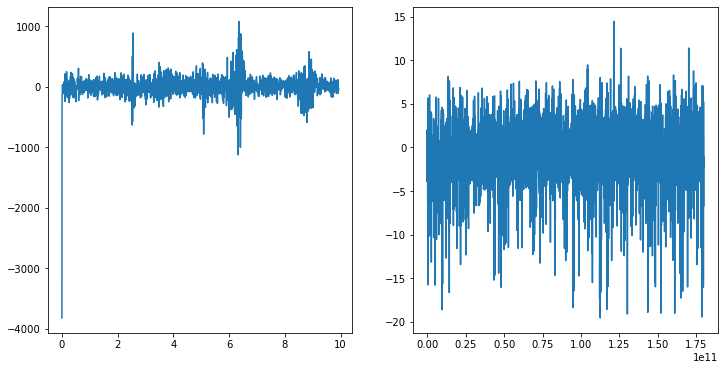

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1.plot(dft1600['B']['freq'], dft1600['B']['xf'])
ax2.plot(raw1600_dict['B']['timestamp'] - raw1600_dict['B']['timestamp'][0], raw1600_dict['B']['x'])

plt.show()

In [72]:
for k, df in raw1600_dict.items():
    print(k)
    print(df['timestamp'][1] - df['timestamp'][0])

A
50354004
B
50354004
C
50354004
D
50354004
E
50354003
F
50354004
G
50354004
H
50354003
I
50354004
J
50354004
K
50354004
L
50354003
M
50354004
O
50354004
P
50354004
Q
50354004
R
50354003
S
50354004


In [115]:
dft1600['B']['freq']

array([0.00000000e+00, 5.55974073e-03, 1.11194815e-02, ...,
       9.91857747e+00, 9.92413721e+00, 9.92969695e+00])

In [116]:
len(dft1600['B']['freq'])

1787

In [118]:
len(raw1600_dict['B']['timestamp'])

1786

In [20]:
!python --version

Python 3.9.2


In [21]:
!jupyter --version

jupyter core     : 4.7.1
jupyter-notebook : 6.3.0
qtconsole        : not installed
ipython          : 7.22.0
ipykernel        : 5.5.3
jupyter client   : 6.1.12
/Users/rtsang/anaconda3/envs/ecs171/lib/python3.9/site-packages/jupyter_server/transutils.py:13: FutureWarning: The alias `_()` will be deprecated. Use `_i18n()` instead.
  warnings.warn(warn_msg, FutureWarning)
jupyter lab      : 3.0.12
nbconvert        : 6.0.7
ipywidgets       : not installed
nbformat         : 5.1.2
traitlets        : 5.0.5


In [3]:
def func(x):
    print(x, flush=True)
    return x*x

t = time()
with Pool(processes=2) as pool:
    
    result = pool.map(func, [i for i in range(4)])
    
print(result)
print(time()-t)

10

23

[0, 1, 4, 9]
0.17288804054260254


In [23]:
nfilt=40
NFFT=1200
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (20 / 2) / 700))  # Convert Hz to Mel
print(high_freq_mel)
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
print(mel_points)
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
print(hz_points)
bin = np.floor((NFFT + 1) * hz_points / 20)

15.986001089003835
[ 0.          0.38990247  0.77980493  1.1697074   1.55960986  1.94951233
  2.33941479  2.72931726  3.11921972  3.50912219  3.89902466  4.28892712
  4.67882959  5.06873205  5.45863452  5.84853698  6.23843945  6.62834191
  7.01824438  7.40814685  7.79804931  8.18795178  8.57785424  8.96775671
  9.35765917  9.74756164 10.13746411 10.52736657 10.91726904 11.3071715
 11.69707397 12.08697643 12.4768789  12.86678136 13.25668383 13.6465863
 14.03648876 14.42639123 14.81629369 15.20619616 15.59609862 15.98600109]
[ 0.          0.24221859  0.484521    0.72690725  0.96937737  1.21193139
  1.45456935  1.69729126  1.94009716  2.18298707  2.42596104  2.66901908
  2.91216122  3.1553875   3.39869794  3.64209257  3.88557142  4.12913453
  4.37278191  4.6165136   4.86032963  5.10423003  5.34821482  5.59228403
  5.83643771  6.08067586  6.32499853  6.56940574  6.81389752  7.0584739
  7.30313491  7.54788058  7.79271094  8.03762602  8.28262584  8.52771045
  8.77287985  9.01813409  9.263473

In [24]:
bin

array([  0.,  14.,  29.,  43.,  58.,  72.,  87., 101., 116., 131., 145.,
       160., 174., 189., 204., 218., 233., 247., 262., 277., 291., 306.,
       321., 335., 350., 365., 379., 394., 409., 423., 438., 453., 467.,
       482., 497., 512., 526., 541., 556., 571., 585., 600.])

In [27]:
np.linspace(0, 10, 11)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])